In [56]:
import os
import os.path as op
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import skimage.io
import skimage.filters
import skimage.morphology
from skimage.filters import try_all_threshold
import matplotlib.image as mpimg
from scipy import ndimage as ndi
from skimage import exposure

In [141]:
path = '/Desktop/temp_images/NP_penetration/' # The folder where the .tiff files are located

In [142]:
img = skimage.io.imread(os.path.expanduser('~')+path+'3p_40nm_brain_1_cortex_100x_z_stack_1.tif')
print(img.shape)
print(img.dtype)

(146, 1024, 1024)
uint16


In [143]:
DAPI = img[0::2]
NP = img[1::2]

print(DAPI.shape)
print(NP.shape)

(73, 1024, 1024)
(73, 1024, 1024)


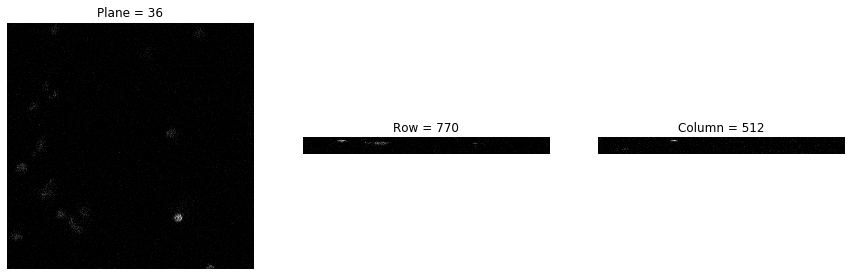

In [32]:
def show_plane(ax, plane, cmap="gray", title=None):
    ax.imshow(plane, cmap=cmap)
    ax.axis("off")

    if title:
        ax.set_title(title)


(n_plane, n_row, n_col) = DAPI.shape
_, (a, b, c) = plt.subplots(ncols=3, figsize=(15, 5))

show_plane(a, DAPI[n_plane // 2], title=f'Plane = {n_plane // 2}')
show_plane(b, DAPI[:, 770, :], title=f'Row = {770}')
show_plane(c, DAPI[:, :, n_col // 2], title=f'Column = {n_col // 2}')

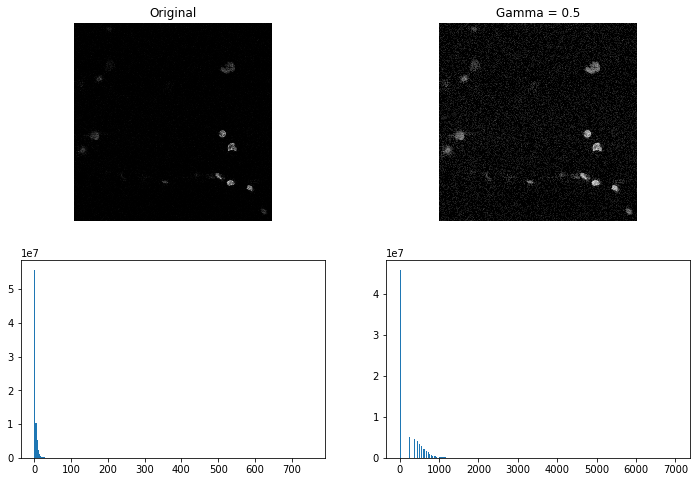

In [33]:
## For now, just using this function to adjust brightness and make the images more viewer friendly

def plot_hist(ax, data, title=None):
    # Helper function for plotting histograms
    ax.hist(data.ravel(), bins=256)
    ax.ticklabel_format(axis="y", style="scientific", scilimits=(0, 0))

    if title:
        ax.set_title(title)


gamma_low_val = 0.5
gamma_low = exposure.adjust_gamma(DAPI, gamma=gamma_low_val)

_, ((a, b), (d, e)) = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

show_plane(a, DAPI[14], title='Original')
show_plane(b, gamma_low[14], title=f'Gamma = {gamma_low_val}')

plot_hist(d, DAPI)
plot_hist(e, gamma_low)

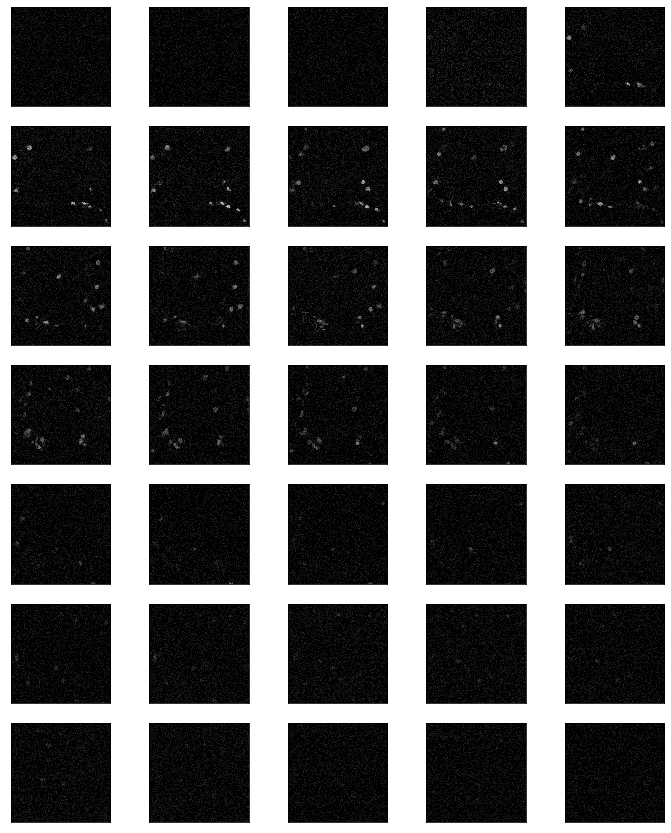

In [34]:
## This function can be used to look through subsequent steps of the entire volume of the z-stack

def display(im3d, cmap="gray", step=2):
    _, axes = plt.subplots(nrows=7, ncols=5, figsize=(12, 15))

    vmin = im3d.min()
    vmax = im3d.max()

    for ax, image in zip(axes.flatten(), im3d[::step]):
        ax.imshow(image, cmap=cmap, vmin=vmin, vmax=vmax)
        ax.set_xticks([])
        ax.set_yticks([])


display(gamma_low)

In [35]:
DAPI_intensities = np.sum(np.sum(DAPI, axis=1), axis=1)
NP_intensities = np.sum(np.sum(NP, axis=1), axis=1)
DAPI_intensities.shape
NP_intensities.shape

(73,)

In [36]:
z = np.arange(len(DAPI_intensities))
z.shape

(73,)

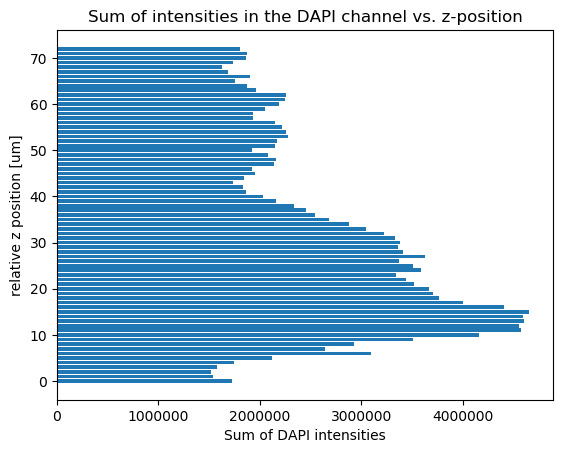

In [37]:
plt.rcdefaults()
fig, ax = plt.subplots()

ax.barh(z, DAPI_intensities, align='center')
ax.set_ylabel('relative z position [um]')
ax.set_xlabel('Sum of DAPI intensities')
ax.set_title('Sum of intensities in the DAPI channel vs. z-position')

plt.show()

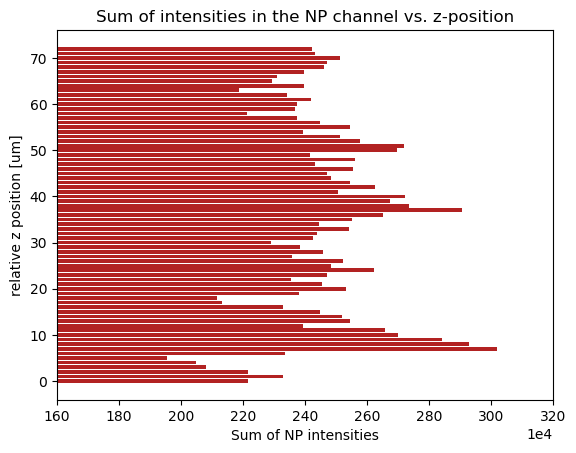

In [176]:
plt.rcdefaults()
fig, ax = plt.subplots()

ax.barh(z, NP_intensities, align='center', color='firebrick')
ax.set_ylabel('relative z position [um]')
ax.set_xlabel('Sum of NP intensities')
ax.set_title('Sum of intensities in the NP channel vs. z-position')
ax.axes.set_xlim(1600000, 3200000)
ax.ticklabel_format(axis='x', style='sci', scilimits=(4,4))

plt.show()

In [40]:
"""" Currently working on how to decide where we've officially "entered" a z-plane within the slice.
    Definitely not sure if this is a proper way to do it, but I first just want to subtract out the average DAPI
    intensity that exists in the first 4 and last 4 z-planes, where I know we're not in the slice and all signal 
    should be attributed to autofluorescence."""

subtract_val = np.mean(np.array([np.mean(np.mean(DAPI, axis=1), axis=1)[0:4],np.mean(np.mean(DAPI, axis=1), axis=1)[-4:]]))
DAPI_int_adj = DAPI_intensities-(subtract_val*1024*1024)

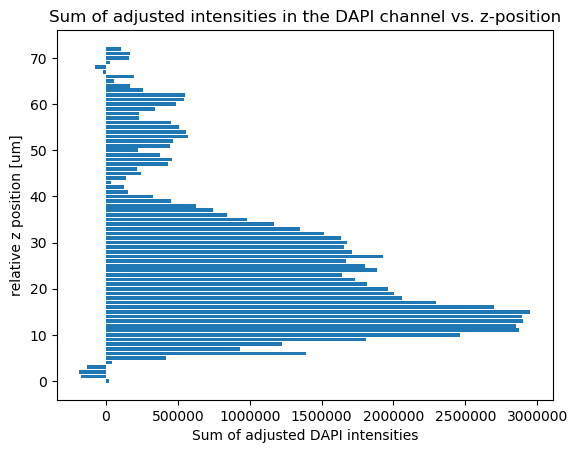

In [43]:
plt.rcdefaults()
fig, ax = plt.subplots()

ax.barh(z, DAPI_int_adj, align='center')
ax.set_ylabel('relative z position [um]')
ax.set_xlabel('Sum of adjusted DAPI intensities')
ax.set_title('Sum of adjusted intensities in the DAPI channel vs. z-position')

plt.show()

Now I'm going to use a series of processing steps to determine the number of blobs (in this case cell nuclei) present in each z stack. I've played around in ImageJ to figure out the properties that work best for this particular image. Hopefully it is easily adaptable to other images within the set.

In [144]:
DAPI.shape

(73, 1024, 1024)

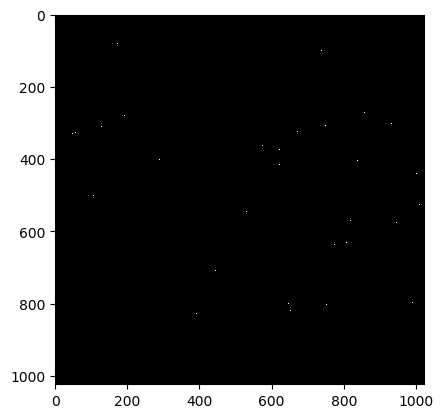

In [154]:
threshold = 38
DAPI_binary = DAPI >= threshold
DAPI_binary_plot = plt.imshow(1-DAPI_binary[5], cmap='Greys')
plt.show()

In [158]:
DAPI_count = np.zeros(DAPI.shape[0])


for z in range(0,DAPI.shape[0]):
    dilated = skimage.morphology.binary_dilation(DAPI_binary[z])
    eroded = skimage.morphology.binary_erosion(dilated)
    eroded = ndi.binary_fill_holes(eroded)
    DAPI_clean = skimage.morphology.remove_small_objects(eroded, min_size=50)
    _, DAPI_count[z] = ndi.label(DAPI_clean)

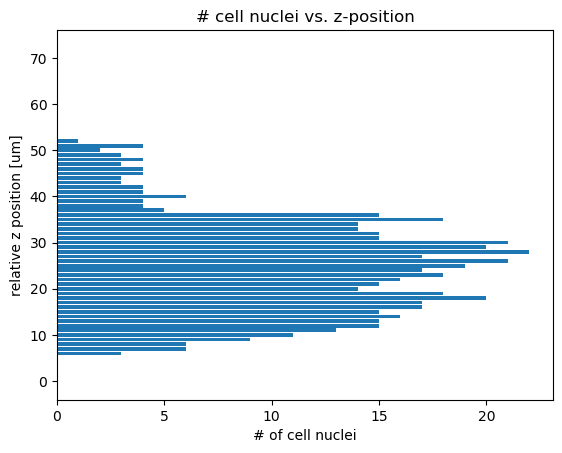

The z-stack first enters the slice at the 7th z-plane


In [169]:
z = np.arange(len(DAPI_intensities))

def first_nonzero(arr, invalid_val=-1):
    mask = arr!=0
    return np.where(mask.any(), mask.argmax(), invalid_val)

tissue_bottom = 1+first_nonzero(DAPI_count)

plt.rcdefaults()
fig, ax = plt.subplots()

ax.barh(z, DAPI_count, align='center')
ax.set_ylabel('relative z position [um]')
ax.set_xlabel('# of cell nuclei')
ax.set_title('# cell nuclei vs. z-position')

plt.show()
print('The z-stack first enters the slice at the %dth z-plane' % tissue_bottom)

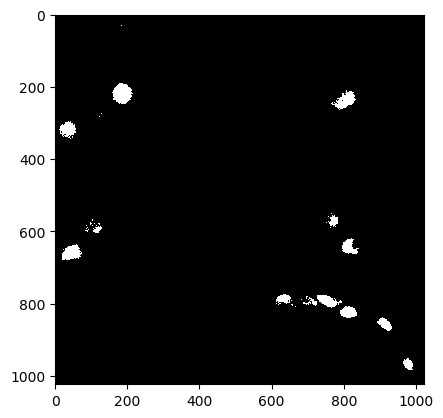

In [136]:
DAPI_clean_plot = plt.imshow(1-DAPI_clean[12], cmap='Greys')
plt.show()

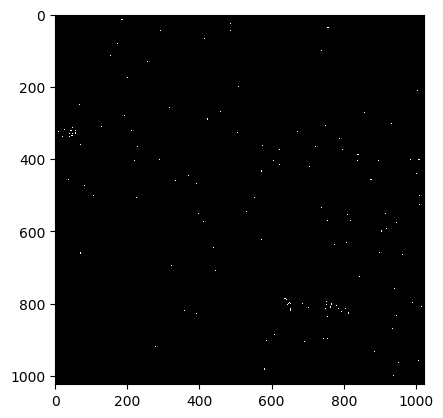

In [146]:
dilated = skimage.morphology.binary_dilation(DAPI_binary[5])
DAPI_dilated_plot = plt.imshow(1-dilated, cmap='Greys')
plt.show()

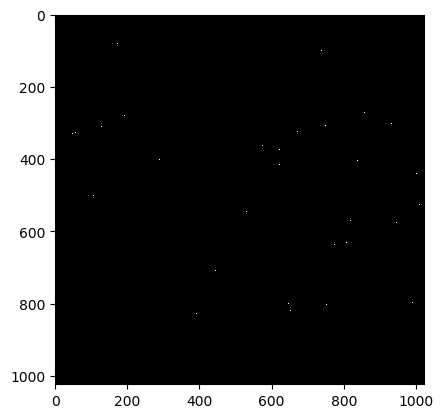

In [147]:
eroded = skimage.morphology.binary_erosion(dilated)
eroded = ndi.binary_fill_holes(eroded)
#DAPI_clean = skimage.morphology.remove_small_objects(eroded, min_size=50)
DAPI_erode_plot = plt.imshow(1-eroded, cmap='Greys')
plt.show()